# Recommend Songs: Unsupervised Clustering and Mean Vectors
___

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px

from sklearn.metrics import silhouette_score
from get_tracks_methods import authenticate

import spotipy
import spotipy.oauth2 as oauth2

- Load Library of Songs

In [48]:
library = pd.read_csv('../data/user_lib_tracks_feats.csv',index_col=0)

In [49]:
library.head()

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1nFtiJxYdhtFfFtfXBv06s,Something In The Way,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,73,False,1,...,-13.044,1,0.0317,0.745000,0.263000,0.1090,0.0668,105.218,232147,4
1,5Ddlk6C2JVxb1SReZ6O1wk,Drain You,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,63,False,1,...,-5.625,0,0.0695,0.000129,0.000002,0.1840,0.1980,133.358,223880,4
2,4l012k8ZcAdVbUvZ4kae5Q,Stay Away,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,56,False,1,...,-5.100,0,0.1280,0.000005,0.046100,0.0822,0.2050,165.210,211440,4
3,2YodwKJnbPyNKe8XXSE9V7,Lithium,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,72,False,1,...,-6.410,1,0.0381,0.001740,0.000000,0.0631,0.4850,123.207,257053,4
4,4P5KoWXOxwuobLmHXLMobV,Come As You Are,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,78,False,1,...,-5.846,0,0.0388,0.000160,0.001610,0.0916,0.5390,120.125,218920,4


In [4]:
library.columns

Index(['id', 'track_name', 'artist', 'artist_uri', 'album_uri', 'album',
       'release_date', 'popularity', 'explicit', 'user_liked', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

- Drop unnecessary columns for clustering:
- different ids
- different uris
- artist, album, track names for now

___
## Initial Clustering Attempt

- Only want to cluster off of Audio Track Features

In [35]:
audio_features = library.drop(columns=['id','track_name','artist','artist_uri','album_uri','album','release_date']).copy()




In [36]:
audio_features.head(2)

,popularity,explicit,user_liked,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,73,False,1,0.427,0.201,8,-13.044,1,0.0317,0.745000,0.263000,0.109,0.0668,105.218,232147,4
1,63,False,1,0.325,0.929,11,-5.625,0,0.0695,0.000129,0.000002,0.184,0.1980,133.358,223880,4


- Now we scale our features to the same standard scale

In [14]:
sc = StandardScaler()

In [13]:
X = audio_features

In [15]:
X_sc = sc.fit_transform(X)

In [17]:
X_sc = pd.DataFrame(X_sc, columns=sc.get_feature_names_out())

In [18]:
X_sc.head(2)

,popularity,explicit,user_liked,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.593336,-0.348762,4.843131,-0.610497,-1.080433,0.790952,-0.158567,0.739334,-0.580461,0.854262,-0.103758,-0.446952,-1.352315,-0.371083,0.206119,0.272213
1,0.993366,-0.348762,4.843131,-1.115964,1.419795,1.634605,0.720540,-1.352569,-0.122022,-1.140030,-0.757315,0.062152,-0.868228,0.531268,0.113392,0.272213


- With our features scaled, let's instantiate our model and run our first go!

In [20]:
km = KMeans(n_clusters=8, random_state=42)

In [21]:
km.fit(X_sc)

KMeans(random_state=42)

In [22]:
km.cluster_centers_

array([[-5.02764012e-02, -2.38163754e-01, -2.02575676e-01,
        -6.55952887e-01,  7.27064530e-01, -4.19421750e-02,
        -7.44947411e-02, -9.16006159e-03,  8.80869643e-02,
        -4.63413253e-01,  2.48337258e-01,  3.37224348e+00,
        -4.17209124e-01, -8.68095788e-02,  1.39862608e-01,
        -2.15152936e-03],
       [ 3.34973334e-01,  2.84221567e+00, -2.06478002e-01,
         6.50684078e-01,  5.02289708e-01,  2.03559599e-02,
         5.83069219e-01, -1.71505889e-01,  1.10852255e+00,
        -6.04189849e-01, -6.80168145e-01,  8.77729152e-02,
         3.32229469e-01,  1.87161158e-01, -2.18176862e-01,
         1.87731651e-01],
       [-3.07318376e-01, -3.43096177e-01, -2.06478002e-01,
        -1.89262729e-01, -4.80027802e-01, -9.53375004e-02,
         7.90918019e-02,  4.18246723e-01, -3.94118527e-01,
         5.70929099e-01, -2.87915037e-01, -2.51780336e-01,
        -4.40819902e-01, -7.46460783e-02,  5.45799156e-01,
        -1.37999519e-02],
       [ 1.45522357e-01, -3.48761972e

In [23]:
km.labels_

array([7, 7, 7, ..., 5, 2, 2], dtype=int32)

In [24]:
km.predict(X_sc)

array([7, 7, 7, ..., 5, 2, 2], dtype=int32)

In [25]:
audio_features['cluster'] = km.labels_

In [26]:
audio_features.head()

,popularity,explicit,user_liked,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,73,False,1,0.427,0.201,8,-13.044,1,0.0317,0.745000,0.263000,0.1090,0.0668,105.218,232147,4,7
1,63,False,1,0.325,0.929,11,-5.625,0,0.0695,0.000129,0.000002,0.1840,0.1980,133.358,223880,4,7
2,56,False,1,0.367,0.981,11,-5.100,0,0.1280,0.000005,0.046100,0.0822,0.2050,165.210,211440,4,7
3,72,False,1,0.678,0.656,7,-6.410,1,0.0381,0.001740,0.000000,0.0631,0.4850,123.207,257053,4,7
4,78,False,1,0.500,0.824,4,-5.846,0,0.0388,0.000160,0.001610,0.0916,0.5390,120.125,218920,4,7


In [31]:
columns = [col for col in audio_features.columns if col != 'cluster']

In [32]:
audio_features.groupby('cluster').mean()[columns]

,popularity,explicit,user_liked,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
cluster,,,,,,,,,,,,,,,,
0,45.605100,0.034389,0.000773,0.417827,0.727295,5.038253,-12.334492,0.642195,0.086824,0.252846,0.404686,0.671635,0.320238,114.083131,226239.948609,3.862056
1,52.026249,0.992205,0.000000,0.681498,0.661847,5.259784,-6.785151,0.564588,0.170963,0.200266,0.031047,0.187774,0.523355,122.626956,194319.016386,3.957525
2,41.323102,0.001760,0.000000,0.512361,0.375990,4.840704,-11.029330,0.847195,0.047108,0.638937,0.188730,0.137710,0.314288,114.437963,261968.513641,3.856326
3,48.880536,0.000000,0.000000,0.628519,0.709423,4.951946,-6.737070,1.000000,0.075298,0.177855,0.111964,0.163552,0.593528,125.151648,211268.143395,3.955265
4,46.522088,0.000000,0.000000,0.645232,0.673254,6.132363,-7.339562,0.000000,0.084635,0.229083,0.184367,0.160364,0.547092,122.049213,216207.306254,3.958306
5,46.190998,0.002099,0.001399,0.306497,0.137260,4.704058,-25.263236,0.725513,0.055972,0.874398,0.794269,0.126800,0.177083,102.932406,190722.961754,2.620336
6,46.026380,0.000000,0.000000,0.378351,0.117995,4.849227,-24.126451,0.710596,0.056422,0.909804,0.868546,0.118054,0.191423,100.548154,182526.394371,4.086645
7,38.203984,0.130279,1.000000,0.584778,0.548735,5.380876,-9.884194,0.671315,0.086699,0.382200,0.219402,0.192013,0.518120,118.258145,231116.361753,3.935458


Silhouette score on first go:
- The Silhoueete score will be our primary metric for understanding the performance of our KMeans
- Sil Score is a measure of how close each point in one cluster is to the points in the neighboring clusters.
- Effectively a measure of how distinct clusters are:
    - Ranges from -1 to 1, -1 being the worst
    - Each point is a measure of how similar that point is to its own cluster compared to other clusters

In [34]:
silhouette_score(X_sc, km.labels_)

0.12899502104130864

- poor performance with the first clustering attempt, but I also think i needed to remove user_liked as well as try some gridsearching like we did in the clustering lesson

In [37]:
X1 = audio_features.drop(columns=['user_liked'])

In [39]:
X1_sc = sc.fit_transform(X1)

In [40]:
X1_sc = pd.DataFrame(X1_sc, columns = sc.get_feature_names_out())

In [41]:
X1_sc.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1.593336,-0.348762,-0.610497,-1.080433,0.790952,-0.158567,0.739334,-0.580461,0.854262,-0.103758,-0.446952,-1.352315,-0.371083,0.206119,0.272213
1,0.993366,-0.348762,-1.115964,1.419795,1.634605,0.720540,-1.352569,-0.122022,-1.140030,-0.757315,0.062152,-0.868228,0.531268,0.113392,0.272213
2,0.573387,-0.348762,-0.907830,1.598382,1.634605,0.782750,-1.352569,0.587468,-1.140361,-0.642761,-0.628872,-0.842401,1.552651,-0.026140,0.272213
3,1.533339,-0.348762,0.633349,0.482209,0.509735,0.627522,0.739334,-0.502842,-1.135717,-0.757320,-0.758524,0.190710,0.205761,0.485476,0.272213
4,1.893321,-0.348762,-0.248741,1.059185,-0.333917,0.694353,-1.352569,-0.494352,-1.139947,-0.753319,-0.565065,0.389953,0.106932,0.057759,0.272213


- Train multiple KMeans with different n_clusters to find the best performance score
- n_clusters sets the number of clusters the algorithm will try to identify in your data.
    - If we make n_clusters too small, we have risk that the distinct groups could merge resulting in loss of information
    - If we make n_clusters too large, we risk affecting interpretability
    - As we increase n_clusters, the computational cost increases

In [43]:
%%time
# taken from kmeans lesson
scores = []

for k in range(2, 31):
    cl = KMeans(n_clusters=k, random_state=42)
    cl.fit(X1_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X1_sc, cl.labels_)
    
    scores.append([k, inertia, sil])

score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette_score']

CPU times: user 33min 13s, sys: 35min 24s, total: 1h 8min 37s
Wall time: 13min 39s


In [44]:
score_df

,k,inertia,silhouette_score
0,2,729232.441777,0.227271
1,3,660868.790873,0.210814
2,4,620694.937979,0.146830
3,5,590264.989377,0.150056
4,6,564165.587233,0.133922
5,7,541270.728503,0.131529
6,8,522400.377773,0.131593
7,9,504779.006061,0.123467
8,10,489702.545525,0.113182
9,11,474629.026767,0.113158


### Initial KMeans Clustering Attempts analysis

- overall poor model performance over a range of possible k values
- highest sil score fromt his batch was 0.22 with k=2
- While these attempts were on a new set of data aside from the set we did the initial EDA on, I was hoping to see some semblance of the pattern we diagnosed in the inital EDA where:
    - Danceability, Valence, and Energy values were the trends for my particular music taste
- However, especially given the immensity of the number of records increased over the original dataset, without some kind of guidance to weigh the clustering on a pattern (in this case a users music taste) the clusters will be more dense around their like metadata categories such as genre
- Moving forward I will be referencing the below article to get closer to my desired outcome of supervised K means clustering around the vector of a given users music taste audio features
- https://towardsdatascience.com/how-to-build-an-amazing-music-recommendation-system-4cce2719a572

___
### Attempt #1 at Identifying Vector range for a User's Music taste based on explicit interactions

- First order of business is to retain the release date of the tracks and transform it into only the year for an additional parameter
    - The lower silhouette score to me reads as a combination of too few records and potentially not enough dimensions to classify tracks

In [5]:
library.head()

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1nFtiJxYdhtFfFtfXBv06s,Something In The Way,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,73,False,1,...,-13.044,1,0.0317,0.745000,0.263000,0.1090,0.0668,105.218,232147,4
1,5Ddlk6C2JVxb1SReZ6O1wk,Drain You,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,63,False,1,...,-5.625,0,0.0695,0.000129,0.000002,0.1840,0.1980,133.358,223880,4
2,4l012k8ZcAdVbUvZ4kae5Q,Stay Away,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,56,False,1,...,-5.100,0,0.1280,0.000005,0.046100,0.0822,0.2050,165.210,211440,4
3,2YodwKJnbPyNKe8XXSE9V7,Lithium,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,72,False,1,...,-6.410,1,0.0381,0.001740,0.000000,0.0631,0.4850,123.207,257053,4
4,4P5KoWXOxwuobLmHXLMobV,Come As You Are,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,78,False,1,...,-5.846,0,0.0388,0.000160,0.001610,0.0916,0.5390,120.125,218920,4


In [55]:
library['release_year'] = pd.to_datetime(library['release_date'],errors='coerce').dt.year

- Needed to pass errors = 'coerce' in the to datetime call as it appears there are some null or missing values for release date or at least the year field is missing. Let's take a closer look

In [56]:
library['release_year'].isnull().value_counts()

False    61576
True         4
Name: release_year, dtype: int64

In [57]:
library['release_year'].isnull().sum()

4

In [58]:
library.loc[library['release_year'].isnull()]

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_year
112,4LLvxxkWtt818FNO3cbsdo,NaN,NaN,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,spotify:album:6HBa9wXaZG8WIkhBY8p4aT,NaN,0000,0,False,1,...,1,0.0635,0.0939,0.000004,0.1050,0.877,145.037,211034,4,NaN
11998,1e6kD8AXQ152lFZLr7kKPN,NaN,NaN,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,spotify:album:6dNfuaaTMb3A3hMBfk9zQF,NaN,0000,0,False,0,...,1,0.0322,0.3160,0.000067,0.3240,0.929,120.117,273133,4,NaN
55716,5n7P6A365Prut3q8vo5G4m,NaN,NaN,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,spotify:album:1oZVS1RjOOZjLhPguAENAD,NaN,0000,0,False,0,...,1,0.2800,0.0340,0.000000,0.0475,0.702,100.049,201600,4,NaN
55866,6Y1cH3RzDCMWGQtOS0HmP8,NaN,NaN,spotify:artist:0LyfQWJT6nXafLPZqxe9Of,spotify:album:6NucTCpJkSWDphKnLBXp6P,NaN,0000,0,False,0,...,1,0.0597,0.7950,0.000000,0.2240,0.726,125.530,246883,5,NaN


- As there is no way to retain or search any value for these records, let's drop as it is only 4 additional records out of ~61k

In [28]:
library.isnull().sum()

id                  0
track_name          4
artist              4
artist_uri          0
album_uri           0
album               4
release_date        0
popularity          0
explicit            0
user_liked          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
release_year        4
dtype: int64

In [59]:
library.dropna(axis=0, inplace=True)

In [30]:
library.isnull().sum()

id                  0
track_name          0
artist              0
artist_uri          0
album_uri           0
album               0
release_date        0
popularity          0
explicit            0
user_liked          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
release_year        0
dtype: int64

In [60]:
library.shape

(61576, 24)

- Quickly change release year into int for future processing

In [61]:
library['release_year']=library['release_year'].astype(int)

In [33]:
library.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61576 entries, 0 to 61579
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                61576 non-null  object 
 1   track_name        61576 non-null  object 
 2   artist            61576 non-null  object 
 3   artist_uri        61576 non-null  object 
 4   album_uri         61576 non-null  object 
 5   album             61576 non-null  object 
 6   release_date      61576 non-null  object 
 7   popularity        61576 non-null  int64  
 8   explicit          61576 non-null  bool   
 9   user_liked        61576 non-null  int64  
 10  danceability      61576 non-null  float64
 11  energy            61576 non-null  float64
 12  key               61576 non-null  int64  
 13  loudness          61576 non-null  float64
 14  mode              61576 non-null  int64  
 15  speechiness       61576 non-null  float64
 16  acousticness      61576 non-null  float6

- Final step before continuing is changing explicit from Boolean to Integer

In [62]:
library['explicit'] = library['explicit'].apply(lambda x: 1 if x==True else 0)

In [63]:
library['explicit'].value_counts()

0    54898
1     6678
Name: explicit, dtype: int64

___
#### According to the article that I am using as a guide, our next steps are:
- 1. Compute the average vector of the audio and metadata features for each song the user has listened to
    - a. For me that is the Explicit and Implicit interactions I categorized as user_liked = 1
    - b. This is also exactly what I have been looking to do re: core audio features from a given users profile
- 2. Find the n-closest data points in the dataset(excluding the points form the songs in the user's listening history) to this average vector
    - a. for me that is the general pool of tracks outside of explicit and implicit interactions I categorized as user_liked = 0
    - b. From the various articles and papers i read, two methods have popped up the most frequently to determine closest distance:
        - i. Euclidean Distance (which is why I initially ran some KMeans Clustering)
        - ii. Cosine difference
    - c. I had to read up on the Cosine difference but essentially it takes 1 minus the cos of the angle of the two vectors.
        - i. If the vectors are pointing in the same direction, the cos of the angle will be 1 and the distance will be 1-1
        - ii. If the vectors are pointing in the opposite directions, the cos of the angle will be -1 and the distance will be 2 (1-(-1))
        - iii. Anywhere in the middle will be 1-n
- 3. Take these n points and recommend the songs corresponding to them to the user

Article: Article: https://towardsdatascience.com/how-to-build-an-amazing-music-recommendation-system-4cce2719a572

___
### Step 1: Compute the average vector of the audio and metadata features for each song the user has listened to:

- Select only numerical columns minus user_liked

In [64]:
num_columns1 = library.select_dtypes(np.number).drop(columns=['user_liked']).columns

- Separate out exp/imp tracks from general pool

In [65]:
exp_imp_tracks = library[library['user_liked']==1]

In [18]:
general_pool = library[library['user_liked']==0]

In [66]:
exp_imp_tracks.shape

(2517, 24)

In [53]:
general_pool.shape

(59059, 25)

In [54]:
general_pool.head()

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_year,cluster_labels
2518,11LmqTE2naFULdEP94AUBa,Heart-Shaped Box,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:6ohX7moZZnF1FwYrli1OJ6,In Utero - 20th Anniversary - Deluxe Edition,1993-09-21,80,0,0,...,0.0552,0.199000,0.032900,0.0853,0.382,203.006,281160,4,1993,6
2519,15VRO9CQwMpbqUYA7e6Hwg,The Man Who Sold The World,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:1To7kv722A8SpZF789MZy7,MTV Unplugged In New York,1994-11-01,77,0,0,...,0.0832,0.425000,0.000142,0.2570,0.420,115.102,261093,4,1994,5
2520,55yvzYuvJYG2RUEnMK78tr,About A Girl,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:5zBPRXCAc801vyHWoRurNZ,Nirvana,2002-10-29,76,0,0,...,0.0339,0.000019,0.000002,0.3100,0.591,131.761,166640,4,2002,1
2521,5gRcv46AMTrosmTOqrOV3Q,Dumb,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:7wOOA7l306K8HfBKfPoafr,In Utero - 20th Anniversary Remaster,1993-09-21,76,0,0,...,0.0281,0.428000,0.653000,0.1730,0.876,113.589,151893,4,1993,5
2522,1Ic9pKxGSJGM0LKeqf6lGe,All Apologies,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:7wOOA7l306K8HfBKfPoafr,In Utero - 20th Anniversary Remaster,1993-09-21,74,0,0,...,0.0340,0.079300,0.000266,0.0881,0.359,113.176,233173,4,1993,5


- Save initial recommendation library

In [55]:
general_pool.to_csv('./app/recommend_library.csv')

In [67]:
exp_imp_tracks.columns

Index(['id', 'track_name', 'artist', 'artist_uri', 'album_uri', 'album',
       'release_date', 'popularity', 'explicit', 'user_liked', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_year'],
      dtype='object')

In [68]:
exp_imp_tracks[num_columns1].shape[1]

16

- Define function to calculate the mean vector of the 16 expected numerical columns from a given dataframe

In [19]:
# Learned from Amol Mavuduru's mean vector function from:
# https://towardsdatascience.com/how-to-build-an-amazing-music-recommendation-system-4cce2719a572

def get_mean_vector(df):
    """
    This function is designed to take in a dataframe of track audio features and create the mean
    of a song matrix made up of the individual track features.
    :param df: a pandas dataframe of individual track and its audio features
    :return mean_vector: a song matrix mean vector to highlight a user's music taste signal
    """
    # set an empty list for each tracks audio feature values
    song_vectors = []
    # iterate through the rows of the given dataframe
    for index, row in df.iterrows():
        # append track audio feature values to song vectors list
        song_vectors.append(row.values)
    # create a matrix/np array out of song vectors list
    song_matrix = np.array(list(song_vectors))
    # calculate the mean of the song_matrix
    mean_vector = np.mean(song_matrix, axis=0)
    # return song vector
    return mean_vector

In [29]:
mean_vector = get_mean_vector(exp_imp_tracks[num_columns])

In [30]:
mean_vector

array([ 3.82212952e+01,  1.29916567e-01,  5.83723758e-01,  5.47739690e-01,
        5.37822805e+00, -9.90921414e+00,  6.71036949e-01,  8.66164482e-02,
        3.83642488e-01,  2.20152710e-01,  1.92429599e-01,  5.16761343e-01,
        1.18271827e+02,  2.31003600e+05,  3.92808899e+00,  2.00689392e+03])

- Successfully calculated our first mean vector!

___
### Step 2: Find the n-closest data points in the dataset(excluding the points form the songs in the user's listening history) to this average vector:
- In order to accomplish this, let's create a kmeans pipeline.
- Once we have a working MVP we can analyze the function and make improvements, for now let's focus on getting a working model

In [31]:
# Based initial pipeline off Amol Mavuduru's from:
# https://towardsdatascience.com/how-to-build-an-amazing-music-recommendation-system-4cce2719a572
pipe = Pipeline([('sc', StandardScaler()),
                 ('km',KMeans(n_clusters=20, verbose=2))], verbose=True)

- adding a save pickle file command for later

In [58]:
with open('my_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

- Set X to general pool numerical columns

In [32]:
X = general_pool[num_columns]

- Note: cluster label is included in the below columns because it was rerun after the initial prediction

In [150]:
X = library.select_dtypes(np.number).drop(columns=['user_liked','cluster_label'])

In [33]:
X.head()

,popularity,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_year
2518,80,0,0.256,0.641,1,-10.283,1,0.0552,0.199000,0.032900,0.0853,0.382,203.006,281160,4,1993
2519,77,0,0.483,0.753,1,-8.937,0,0.0832,0.425000,0.000142,0.2570,0.420,115.102,261093,4,1994
2520,76,0,0.409,0.932,11,-4.538,0,0.0339,0.000019,0.000002,0.3100,0.591,131.761,166640,4,2002
2521,76,0,0.697,0.395,6,-13.580,1,0.0281,0.428000,0.653000,0.1730,0.876,113.589,151893,4,1993
2522,74,0,0.446,0.632,1,-12.197,1,0.0340,0.079300,0.000266,0.0881,0.359,113.176,233173,4,1993


- 16 Features

In [34]:
X.shape

(59059, 16)

In [35]:
pipe.fit(X)

[Pipeline] ................ (step 1 of 2) Processing sc, total=   0.0s
Initialization complete
Iteration 0, inertia 613054.6037927534
Iteration 1, inertia 453094.5010249922
Iteration 2, inertia 439675.0168730235
Iteration 3, inertia 433795.53108481155
Iteration 4, inertia 430961.91033096344
Iteration 5, inertia 428977.5965974984
Iteration 6, inertia 427333.3561163857
Iteration 7, inertia 426171.782365408
Iteration 8, inertia 425541.1706941244
Iteration 9, inertia 425158.3662837519
Iteration 10, inertia 424909.23143267387
Iteration 11, inertia 424728.947202011
Iteration 12, inertia 424596.4259449745
Iteration 13, inertia 424486.689342704
Iteration 14, inertia 424393.8459829797
Iteration 15, inertia 424319.3834601868
Iteration 16, inertia 424261.5927440577
Iteration 17, inertia 424209.6314877481
Iteration 18, inertia 424167.98575413186
Iteration 19, inertia 424135.71010988933
Iteration 20, inertia 424106.38498563005
Iteration 21, inertia 424084.0616157008
Iteration 22, inertia 424063.860

Pipeline(steps=[('sc', StandardScaler()),
                ('km', KMeans(n_clusters=20, verbose=2))],
         verbose=True)

In [36]:
song_cluster_labels = pipe.predict(X)

In [37]:
general_pool['cluster_labels'] = song_cluster_labels

/var/folders/6y/v5glmyqn4txdzjjjjdn0r32w0000gn/T/ipykernel_61615/1123651145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_pool['cluster_labels'] = song_cluster_labels


In [51]:
general_pool

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_year,cluster_labels
2518,11LmqTE2naFULdEP94AUBa,Heart-Shaped Box,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:6ohX7moZZnF1FwYrli1OJ6,In Utero - 20th Anniversary - Deluxe Edition,1993-09-21,80,0,0,...,0.0552,0.199000,0.032900,0.0853,0.382,203.006,281160,4,1993,6
2519,15VRO9CQwMpbqUYA7e6Hwg,The Man Who Sold The World,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:1To7kv722A8SpZF789MZy7,MTV Unplugged In New York,1994-11-01,77,0,0,...,0.0832,0.425000,0.000142,0.2570,0.420,115.102,261093,4,1994,5
2520,55yvzYuvJYG2RUEnMK78tr,About A Girl,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:5zBPRXCAc801vyHWoRurNZ,Nirvana,2002-10-29,76,0,0,...,0.0339,0.000019,0.000002,0.3100,0.591,131.761,166640,4,2002,1
2521,5gRcv46AMTrosmTOqrOV3Q,Dumb,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:7wOOA7l306K8HfBKfPoafr,In Utero - 20th Anniversary Remaster,1993-09-21,76,0,0,...,0.0281,0.428000,0.653000,0.1730,0.876,113.589,151893,4,1993,5
2522,1Ic9pKxGSJGM0LKeqf6lGe,All Apologies,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:7wOOA7l306K8HfBKfPoafr,In Utero - 20th Anniversary Remaster,1993-09-21,74,0,0,...,0.0340,0.079300,0.000266,0.0881,0.359,113.176,233173,4,1993,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61575,2UbPd0NRDK4C0GydEDIQfk,Star of the Country Down,Pat Kirtley,spotify:artist:4wQGu2sZibDxvZIPxEOCr3,spotify:album:14ouePxlOLsGjeptH8lIBC,Ramble to Cashel,2011-08-24,27,0,0,...,0.0427,0.955000,0.921000,0.0871,0.493,119.663,201247,4,2011,19
61576,63y9PsKjVQWxvx4yZ4QMdL,Movement I - Awakening,Maneli Jamal,spotify:artist:3jvyO2jDkfBe2vuI6euFny,spotify:album:6zFlPueRXz2QG5HnfFvem1,The Lamaj Movement,2012-05-20,30,0,0,...,0.0413,0.856000,0.882000,0.1240,0.400,93.761,235653,3,2012,11
61577,5UpCLtzvTE8uNbDzTVSAnc,Altalenanze,Stefano Barone,spotify:artist:3SkmDmTvx0USL6SaL8uDs6,spotify:album:60pGj9J2Z0vjn2d9kzZzsW,Danze Altalenanze,2012-04-17,26,0,0,...,0.0617,0.851000,0.868000,0.1010,0.399,115.959,234998,3,2012,15
61578,5hN8B7iH9FsMgZFkyJtVcC,Rylynn,Don Ross,spotify:artist:3NQRIqPwnKZJ4KLKGSkl2Y,spotify:album:4xrdRzR1WRxZjtLGxR1Pt0,The Thing That Came From Somewhere,2008-01-10,35,0,0,...,0.0358,0.779000,0.882000,0.1070,0.408,77.057,354240,4,2008,3


In [158]:
library['cluster_label'] = song_cluster_labels

In [52]:
library.head()

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_year
0,1nFtiJxYdhtFfFtfXBv06s,Something In The Way,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,73,0,1,...,1,0.0317,0.745000,0.263000,0.1090,0.0668,105.218,232147,4,1991
1,5Ddlk6C2JVxb1SReZ6O1wk,Drain You,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,63,0,1,...,0,0.0695,0.000129,0.000002,0.1840,0.1980,133.358,223880,4,1991
2,4l012k8ZcAdVbUvZ4kae5Q,Stay Away,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,56,0,1,...,0,0.1280,0.000005,0.046100,0.0822,0.2050,165.210,211440,4,1991
3,2YodwKJnbPyNKe8XXSE9V7,Lithium,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,72,0,1,...,1,0.0381,0.001740,0.000000,0.0631,0.4850,123.207,257053,4,1991
4,4P5KoWXOxwuobLmHXLMobV,Come As You Are,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,78,0,1,...,0,0.0388,0.000160,0.001610,0.0916,0.5390,120.125,218920,4,1991


First Pass Complete, using the visualization code from Amol Mavuduru's article to view the results
- Amol takes advantage of PCA for dimensionality reduction as well as it's speed
- For a quick explanation, PCA (Principal Component Analysis) works to find the features in your dataset that explain most of the variation in the dataset
- These principal components are combined into a new set of features and each component is a linear combination of the original features
- The one major downside of using PCA is that all inference is lost as there is very little of the original features to be recognized by humans<br>
- *Editing Note*: I didnt understand it fully at the time, but this was a key indication that there is a dimensionality problem across the data, we need more features to define flusters outside of just audio features

In [41]:
pca_pipeline = Pipeline([('sc', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = general_pool['track_name']
projection['cluster'] = general_pool['cluster_labels']

- Had to comment out in order to reduce the data of this notebook to push it up, below is a picture 
https://myawsbucketdsi221.s3.us-east-2.amazonaws.com/initial_pca.png

![Initial PCA Visualization ](https://myawsbucketdsi221.s3.us-east-2.amazonaws.com/initial_pca.png)


In [1]:
# fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
# fig.show()

- Overall, as mentioned above, not to insightful as to the spread and clustering of the data as it all merges into one
- Where I think this will become a more interactive plot is when we are able to load and save possible genres.
- Genres would enable us to compare potential groupings within the mess and hopefully we would find similar groupings in terms of genres

- One last step before moving onto step 3 which is recommending songs! We need to use cosine distance to get the closest points

- Access Standard Scaler from the fit pipeline

In [43]:
scaler = pipe.steps[0][1]

In [163]:
num_columns = library.select_dtypes(np.number).drop(columns=['user_liked','cluster_label']).columns

In [164]:
num_columns

Index(['popularity', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'release_year'],
      dtype='object')

- Safety check for 16 features

In [165]:
library[num_columns].shape

(61576, 16)

In [44]:
# scale the library data
scaled_data = scaler.transform(general_pool[num_columns])

In [166]:
# scale the library data
scaled_data = scaler.transform(library[num_columns])

In [168]:
X.shape[1] == library[num_columns].shape[1]

True

In [45]:
# scale the calculated mean vector from earlier, need to reshape to a 2d array
scaled_song_center = scaler.transform(mean_vector.reshape(1,-1))

/Users/christopherjoyce/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [46]:
# find the cosine distances between the mean_vector and the scaled library track data
distances = cdist(scaled_song_center, scaled_data, 'cosine')

- A note on cosine distance:
    - cosine distance is a measure of similarity, mathematically between two non-zero vectors of a product space
    - each song is being represented as a high-dimensional vector (16 features)
    - cosine distance measures the cosine of the angle between two vectors.
        - if the angles are identical, the angle between them is 0 degres, cosine of 0 is 1, indicating maximum similarity
        - if the angles are completely dissimilar, they are orthogonal (right angle) to each other, cosine of 90 degrees is 0, indicating no similarity
- By Calculating the cosine distance between the mean vector and the scaled song vectors from the library, we are finding how similar each song is in the libary to the given tracks
    - With a Silhouette score of 0.1, we are barely performing
- Songs with the smallest cosine distance or highest cosine similarity are the ones that are indexed in the top row

In [47]:
# np.argsort(distances) computes the indices that would sort distances in asc order, returns a np array with the same shape
# [:, :10] slices the np array to include only the first 10 columns of each row, effectively grabbing the 10 nearest neighbors
# [0] selects the first row of the sliced np array
# finally we convert it to a list all to get us the indices of the song library that make good recommendations
index = list(np.argsort(distances)[:, :10][0])

- Each index is an observation in the song recommendation library

In [48]:
index

[30553, 57286, 47399, 51708, 14018, 47397, 31229, 30517, 1668, 51450]

In [49]:
recommended_songs = library.iloc[index]
recommended_songs = recommended_songs[['track_name','artist','album','release_year']]

In [50]:
recommended_songs

,track_name,artist,album,release_year
30555,Coffee Bar,Yung Dark,Coffee Bar,2022
57290,لاتسولف,منصور الوايلي,لاتسولف,2023
47401,Faro,Rone,Rone & Friends,2021
51710,Asi no papacito,Anonymous,"Sergio Alvarez: Cuba, Cuba! - The Most Popular...",2005
14020,The Good,Cynthia Erivo,Ch. 1 Vs. 1,2021
47399,Touches Everything,Rival Consoles,Overflow,2021
31231,Little Satchel,Nora Brown,Little Satchel,2022
30519,healing wish,buggy beats,healing wish,2023
1669,When You're Gone,The Piano Guys,When You're Gone,2022
51452,Save The Last Dance For Me,Russ Columbo,Save The Last Dance For Me,2011


___
## Attempting to Introduce Genres

In [60]:
library.head()

,id,track_name,artist,artist_uri,album_uri,album,release_date,popularity,explicit,user_liked,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_year
0,1nFtiJxYdhtFfFtfXBv06s,Something In The Way,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,73,0,1,...,1,0.0317,0.745000,0.263000,0.1090,0.0668,105.218,232147,4,1991
1,5Ddlk6C2JVxb1SReZ6O1wk,Drain You,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,63,0,1,...,0,0.0695,0.000129,0.000002,0.1840,0.1980,133.358,223880,4,1991
2,4l012k8ZcAdVbUvZ4kae5Q,Stay Away,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,56,0,1,...,0,0.1280,0.000005,0.046100,0.0822,0.2050,165.210,211440,4,1991
3,2YodwKJnbPyNKe8XXSE9V7,Lithium,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,72,0,1,...,1,0.0381,0.001740,0.000000,0.0631,0.4850,123.207,257053,4,1991
4,4P5KoWXOxwuobLmHXLMobV,Come As You Are,Nirvana,spotify:artist:6olE6TJLqED3rqDCT0FyPh,spotify:album:2guirTSEqLizK7j9i1MTTZ,Nevermind (Remastered),1991-09-26,78,0,1,...,0,0.0388,0.000160,0.001610,0.0916,0.5390,120.125,218920,4,1991


In [72]:
library.shape

(61576, 24)

One hot encode genres

- import ast found when looking for a way to turn the genre columns that look like lists in df.head() but are actually strings...
- https://docs.python.org/3/library/ast.html#ast.literal_eval
- https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval

In [13]:
import ast
extended_library['genres'] = extended_library['genres'].apply(ast.literal_eval)

- use a set comprehension to only get 

In [ ]:
all_values = set(x for l in extended_library['genres'] for x in l)

In [ ]:
len(all_values)

45

Accidentally reran the above cell, initially it said 4407, further evidence below
- We were successfully able to not only change the list strings back into lists, but we were able to find all unique values, of which there are 4400.
- While understanding that we need more dimensions in our data to create better clusters, by adding too many features, especially after "one hot encoding" the values, we could over correct and make the data sparse. What we are up against with 4400 additional features:
    - `Curse of dimensionality`: In high dimensional spaces, points tend to be far apart, which can make clusters less meaningful. This can also lead to overfitting, where the model may capture noise instead of the underlying pattern.
    - `Computational cost`: More features mean more computational resources and time required to train the model.
    - `Sparsity`: Many machine learning algorithms do not perform well on very sparse data.
    - `Interpretability`: More features can make the model harder to interpret.
- Another approach is to be more selective about which features we include. For example, if some of the 44k unique values only appear occassionally, they may not be very informative.
    - We would probably need another classification model to further be able to classify the greater masses of genres as a higher level 20?
    - Rock, Jazz, Blues, Hip Hop, Rap, etc.
- We should look into any other applications of PCA to potentially give us an idea of features necessary or even simpler the number of n_components to set.


___
### Attempt 1: Unpacking Genres

- Using this link for a list of fundamental music genres:
https://www.blisshq.com/music-library-management-blog/2011/01/25/fundamental-music-genre-list2/


In [35]:
test_library = extended_library.copy()

In [25]:
test_library.head()

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[],1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[],1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"[tango, vintage tango]",1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"[tango, vintage tango]",1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"[adult standards, big band, easy listening, lo...",1922


In [36]:
all_values = set(x for l in test_library['genres'] for x in l)

In [37]:
len(all_values)

4407

- ^

- Having created a list of higher level genres, lets try and create a function that creates a new column for every higher level genre
    - Sets the initial value to 0
- Attempt to use regex to find any 1 instance of a given higher level genre within a list of possible genre values
    - Iterate through the rows of the dataframe
    - combine all the genres for this row into a single string
    - loop through genre regex patterns
    - use the .search function to find a given pattern in a joined string of genres
    - if a higher level genre is found, set the corresponding column at index of row to 1

In [30]:
import re

In [22]:
high_level_genres = ['blues', 'brass & military', 'children', 'classical', 'electronic', 
                     'folk', 'funk', 'soul', 'hip-hop', 'jazz', 'latin', 'non-music', 'pop', 
                     'reggae', 'rock', 'stage & screen', 'rap', 'r&b', 'dance']

- Final Note: after review I noticed that this regex wasnt working as I intended, I thought it was looking for the genre within the list, but it is doing the opposite, it's looking for that genre specifically, and not between anything.

In [31]:
def encode_high_level_genres(df, genres_col, high_level_genres):
    for genre in high_level_genres:
        # Create a new column for each high-level genre
        df[genre] = 0  # Initially set all values to 0

    # Compile regular expressions for each genre
    genre_patterns = {genre: re.compile(r'\b' + genre + r'\b', re.IGNORECASE) for genre in high_level_genres}

    # Iterate through rows and update genre columns
    for idx, row in df.iterrows():
        row_genres = ' '.join(row[genres_col])  # Join all genres for this row into a single string
        for genre, pattern in genre_patterns.items():
            if pattern.search(row_genres):
                df.at[idx, genre] = 1  # If the genre is present, set the corresponding column to 1

    return df

In [32]:
test_library = encode_high_level_genres(test_library, 'genres', high_level_genres)

In [33]:
test_library.columns

Index(['id', 'track_name', 'popularity', 'duration_ms', 'explicit', 'artist',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'genres',
       'release_year', 'blues', 'brass & military', 'children's', 'classical',
       'electronic', 'folk', 'funk / soul', 'hip-hop', 'jazz', 'latin',
       'non-music', 'pop', 'reggae', 'rock', 'stage & screen', 'rap', 'r&b',
       'dance', 'children'],
      dtype='object')

In [34]:
test_library[['genres',
       'release_year', 'blues', 'brass & military', "children's", 'classical',
       'electronic', 'folk', 'funk / soul', 'hip-hop', 'jazz', 'latin',
       'non-music', 'pop', 'reggae', 'rock', 'stage & screen', 'rap', 'r&b',
       'dance', 'children']].head()

,genres,release_year,blues,brass & military,children's,classical,electronic,folk,funk / soul,hip-hop,...,latin,non-music,pop,reggae,rock,stage & screen,rap,r&b,dance,children
0,[],1922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[],1922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[tango, vintage tango]",1922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[tango, vintage tango]",1922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[adult standards, big band, easy listening, lo...",1922,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- At this point noticed and remembered that there are potentially hundreds of higher level genres, or rather some of the higher level genres include tango, but not in language
- This problem is more complex than just a regex solution, if we had more time I or if we had gotten here sooner we could try and create a classification model to tie genres to higher level genres
- Let's plan to do that as a version 1.1

- Clean up the libraries for saving

In [8]:
len(extended_library.select_dtypes(np.number).columns)

16

In [79]:
library.select_dtypes(np.number).drop(columns=['user_liked']).columns

Index(['popularity', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'release_year'],
      dtype='object')

In [95]:
extended_library.head(1)

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,id_y,genres,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.445,...,0.451,0.674,0.744,0.151,0.127,104.851,3,45tIt06XoI0Iio4LBEVpls,[],1922


In [99]:
extended_library.columns

Index(['id', 'track_name', 'popularity', 'duration_ms', 'explicit', 'artist',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'genres',
       'release_year'],
      dtype='object')

In [98]:
extended_library.drop(columns=['id_y'], inplace=True)

In [131]:
extended_library.to_csv("../data/extended_track_library_genres.csv")

In [3]:
extended_library = pd.read_csv("../data/extended_track_library_genres.csv", index_col=0)

___
## Attempting to Strengthen our Models with More Observations

- From attempting to expand the data from genre collection and other features, we've recently started getting throttled by the Spotify Web API
- To save time, and admittedly could have done this earlier, I found a great resource on Kaggle linked below. A 600K+ Track data set from 1921 to 2020.
- It even includes a separate genres folder to merge on artist ids
- Kaggle Dataset: https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks/code?resource=download
- *Editing Note*: Accidentally overwrote the code that I used to merge the tracks with their respective genres

In [23]:
extended_library = pd.read_csv("../data/extended_track_library_genres.csv",index_col=0)

In [4]:
extended_library.head()

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[],1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[],1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"['tango', 'vintage tango']",1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"['tango', 'vintage tango']",1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"['adult standards', 'big band', 'easy listenin...",1922


In [5]:
extended_library.shape

(470038, 22)

- Only ~38k dont have genres

In [8]:
extended_library.shape[0]-extended_library[extended_library['genres']!='[]'].shape[0]

37810

In [9]:
new_rec_lib = extended_library[extended_library['genres']!='[]']

In [12]:
og_lib = pd.read_csv("../data/user_lib_tracks_feats.csv",index_col=0)

In [13]:
og_lib.shape

(61580, 23)

- Checking to see how many songs are common accross the songs I pulled from playlists and songs from this kaggle dataset

In [14]:
common_ids = new_rec_lib['id'].isin(og_lib['id']).sum()
print(f"There are {common_ids} common IDs.")

There are 8586 common IDs.


# Song Recommendation Workflow

___
## Step 1: Mean vector

### Model without Genres

In [39]:
extended_library

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,[],1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,[],1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,"[tango, vintage tango]",1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,"[tango, vintage tango]",1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,"[adult standards, big band, easy listening, lo...",1922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586665,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,Gregory Oberle,4MxqhahGRT4BPz1PilXGeu,2020-03-20,0.562,0.0331,...,1,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,[instrumental lullaby],2020
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿YueYue,1QLBXKM5GCpyQQSVMNZqrZ,2020-09-26,0.560,0.5180,...,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,[chinese viral pop],2020
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,ROLE MODEL,1dy5WNgIKQU6ezkpZs4y8z,2020-10-21,0.765,0.6630,...,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,"[alt z, alternative r&b, bedroom pop, indie ca...",2020
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,FINNEAS,37M5pPGs6V1fchFJSgCguX,2020-09-02,0.535,0.3140,...,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,"[alt z, electropop, indie pop, la indie, pop, ...",2020


In [40]:
num_columns = extended_library.select_dtypes(np.number).columns

In [42]:
extended_library[num_columns].shape[1]

16

In [44]:
extended_library[num_columns].head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
0,6,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922
1,0,98200,0,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922
2,0,181640,0,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922
3,0,176907,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922
4,0,163080,0,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922


Same Mean vector as my explicit tracks for testing purposes

In [69]:
mean_vector = get_mean_vector(exp_imp_tracks[num_columns])

In [70]:
mean_vector

array([ 3.82212952e+01,  2.31003600e+05,  1.29916567e-01,  5.83723758e-01,
        5.47739690e-01,  5.37822805e+00, -9.90921414e+00,  6.71036949e-01,
        8.66164482e-02,  3.83642488e-01,  2.20152710e-01,  1.92429599e-01,
        5.16761343e-01,  1.18271827e+02,  3.92808899e+00,  2.00689392e+03])

___
## Step 2: Find the n-closest data points in the dataset(excluding the points form the songs in the user's listening history) to this average vector:

New Model for New Library using "Grid Search"

In [71]:
sc = StandardScaler()

In [72]:
X = extended_library[num_columns]

In [73]:
X_sc = sc.fit_transform(X)

In [74]:
X_sc = pd.DataFrame(X_sc, columns = sc.get_feature_names_out())

In [75]:
X_sc.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
0,-1.279950,-0.869949,-0.190407,0.497161,-0.452445,-1.483694,-0.747859,0.710663,1.966674,0.721633,2.688293,-0.340101,-1.731130,-0.483936,-1.926208,-3.141854
1,-1.622908,-1.120064,-0.190407,0.811474,-1.198006,-1.483694,-2.652740,0.710663,4.807953,1.084141,-0.387612,-0.356297,0.358890,-0.579611,-6.305662,-3.141854
2,-1.622908,-0.392976,-0.190407,-0.829238,-1.550303,-1.199630,-2.445754,0.710663,-0.278273,1.664742,-0.297484,-0.010793,-0.424867,0.376768,2.453246,-3.141854
3,-1.622908,-0.434218,-0.190407,-1.539585,-1.887853,0.504753,-3.913928,0.710663,-0.282766,1.667689,3.407657,-0.593831,-0.662370,1.708610,-1.926208,-3.141854
4,-1.622908,-0.554706,-0.190407,-1.030398,-1.628136,-0.631502,-1.519078,-1.407137,-0.346779,1.650006,0.149845,0.523659,-1.458002,-0.538844,0.263519,-3.141854


In [77]:
%%time
# taken from kmeans lesson
scores = []

for k in range(20, 30, 2):
    cl = KMeans(n_clusters=k, random_state=42)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    
    scores.append([k, inertia, sil])

score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette_score']

CPU times: user 5h 41min 37s, sys: 5h 47min 36s, total: 11h 29min 14s
Wall time: 1h 55min 13s


In [78]:
score_df

,k,inertia,silhouette_score
0,20,3.462100e+06,0.102541
1,22,3.404183e+06,0.092449
2,24,3.311202e+06,0.102287
3,26,3.235348e+06,0.099240
4,28,3.194551e+06,0.099878


Reminders about what Silhouette Score and Inerta represent, although inertia is not readable here:<br>
*Silhouette Score*<br>
- `Silhouette Score`: The `Silhouette Score` measures how close each sample in one cluster is to the samples in the neighboring clusters. It's a measure of how similar an object is to its own cluster compared to other clusters.<br>
- The `Silhouette Score` is calculated as follows:<br>
- `s(i) = (b(i) - a(i)) / max{a(i), b(i)}`<br>
- For each sample:<br>
    - `a(i)` is the mean distance between a sample and all other points in the same class.
    - `b(i)` is the mean distance between a sample and all other points in the next nearest cluster.<br>
- The `Silhouette Score` ranges from -1 to 1. If it is high, the object is well-matched to its own cluster and poorly matched to neighboring clusters. If the score is low, the opposite is true.<br>
- Therefore, we generally want the `Silhouette Score` to be `high` as it indicates that the `samples are well clustered` and `the chosen number of clusters is appropriate`.<br>
- Both `inertia` and `silhouette score` offer different perspectives on the performance of the clustering model, and neither is perfect. They should be used together, along with knowledge of the domain and data, to evaluate the clustering model. (Added Note: when possible)
<br>
*Inertia*<br>
- `Inertia`: In the context of KMeans clustering, inertia refers to the sum of squared distances of samples to their nearest cluster center. Mathematically, if we have n clusters C = {C1, C2, ..., Cn} and μi is the centroid for cluster Ci, then inertia is calculated as: <br>
- `Inertia` = `Σ(Σ(||x - μi||²)) for all x in Ci for i from 1 to n`.<br>
- In simpler terms, for each cluster, you calculate the distance of each point in the cluster to the centroid of that cluster, square that, and then sum all those squared distances together. You then repeat this for all clusters and add those sums together to get the inertia.<br>
- A lower inertia value is better as it means the points in the same cluster are closer to each other. However, inertia is highly sensitive to the number of clusters, so it alone is not a reliable metric as the inertia decreases as the number of clusters increases.<br>

Our Model still isnt performing well with the additional rows of data (from 60k to 400k), let's use pca to understand potential k value that works

In [117]:
general_pool = extended_library.copy()

In [118]:
pipe = Pipeline([('sc', StandardScaler()),
                 ('km',KMeans(n_clusters=20, verbose=2))], verbose=True)

In [119]:
pipe.fit(X)

[Pipeline] ................ (step 1 of 2) Processing sc, total=   0.1s
Initialization complete
Iteration 0, inertia 6416050.433329703
Iteration 1, inertia 4925453.733025161
Iteration 2, inertia 4846433.445268889
Iteration 3, inertia 4812178.3841111725
Iteration 4, inertia 4791750.776054377
Iteration 5, inertia 4776790.849166904
Iteration 6, inertia 4761290.748255023
Iteration 7, inertia 4742360.008319926
Iteration 8, inertia 4723880.064860489
Iteration 9, inertia 4712310.892133253
Iteration 10, inertia 4707020.138035457
Iteration 11, inertia 4704763.606712014
Iteration 12, inertia 4703689.400584027
Iteration 13, inertia 4703101.652313286
Iteration 14, inertia 4702736.7883181255
Iteration 15, inertia 4702498.315749899
Iteration 16, inertia 4702344.398866216
Iteration 17, inertia 4702237.488183948
Iteration 18, inertia 4702171.329129026
Iteration 19, inertia 4702125.195206163
Iteration 20, inertia 4702090.515758734
Iteration 21, inertia 4702066.824067302
Iteration 22, inertia 4702049.434

Pipeline(steps=[('sc', StandardScaler()), ('km', KMeans(verbose=2))],
         verbose=True)

In [120]:
song_cluster_labels = pipe.predict(X)

In [121]:
general_pool['cluster_labels'] = song_cluster_labels

In [25]:
# This is where the machine dependency problems started to arise
# This cell can't be run on this local M2 chip
# sil = silhouette_score(X_sc, song_cluster_labels)

In [79]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_sc)

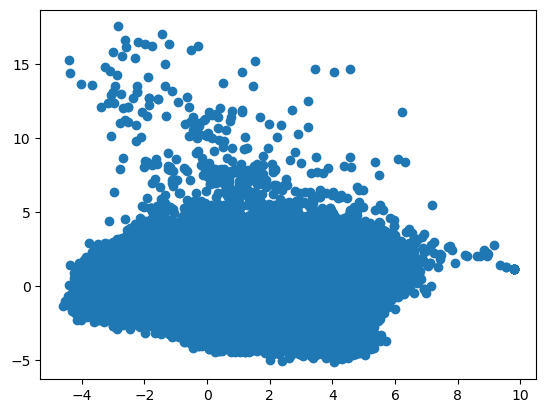

In [80]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

- Created a 2 dimensional scatter plot to check in on the overall shape of the components
- Let's try to create and visualize 3 principle components!

In [122]:
pca_pipeline = Pipeline([('sc', StandardScaler()), ('PCA', PCA(n_components=3))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y', 'z'], data=song_embedding)
projection['title'] = general_pool['track_name']
projection['cluster'] = general_pool['cluster_labels']

- Had to comment these off to lower the memory of this notebook. Similarly, here's a s3 link to an image: https://myawsbucketdsi221.s3.us-east-2.amazonaws.com/pca_3_components.png

![Initial PCA Visualization ](https://myawsbucketdsi221.s3.us-east-2.amazonaws.com/pca_3_components.png)

In [2]:
# fig = px.scatter_3d(projection, x='x', y='y',z='z', color='cluster', hover_data=['x', 'y','z', 'title'])
# fig.show()

- Even with PCA 3 components doesnt seem enough to create valid clusters
- Let us try and one hot encode the genres we do have without classification and risk the high dimensionality
- If the scores are poor, it will at least give some credit that the amount of new features should be less than 4400 even with 400k rows

___
## Model with one hot encoded genres

In [2]:
extended_library = pd.read_csv("../data/extended_track_library_genres.csv",index_col=0)

In [3]:
extended_library.head()

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[],1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[],1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"['tango', 'vintage tango']",1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"['tango', 'vintage tango']",1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"['adult standards', 'big band', 'easy listenin...",1922


In [4]:
extended_library.shape

(470038, 22)

In [4]:
genres_attempt = extended_library.copy()

In [6]:
genres_attempt.head()

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[],1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[],1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"['tango', 'vintage tango']",1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"['tango', 'vintage tango']",1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"['adult standards', 'big band', 'easy listenin...",1922


In [7]:
genres_attempt.columns

Index(['id', 'track_name', 'popularity', 'duration_ms', 'explicit', 'artist',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'genres',
       'release_year'],
      dtype='object')

In [8]:
genres_attempt['genres']

0                                                        []
1                                                        []
2                                ['tango', 'vintage tango']
3                                ['tango', 'vintage tango']
4         ['adult standards', 'big band', 'easy listenin...
                                ...                        
586665                             ['instrumental lullaby']
586667                                ['chinese viral pop']
586668    ['alt z', 'alternative r&b', 'bedroom pop', 'i...
586669    ['alt z', 'electropop', 'indie pop', 'la indie...
586671                    ['chicha', 'cumbia', 'nu-cumbia']
Name: genres, Length: 470038, dtype: object

- Change Strings to Lists

In [3]:
import ast
extended_library['genres'] = extended_library['genres'].apply(ast.literal_eval)

In [26]:
# set comprehension to only get unique values
all_values = set(x for l in extended_library['genres'] for x in l)

In [6]:
# Create a list of one-hot encoded Series
one_hot_encoded = [extended_library['genres'].apply(lambda x: 1 if value in x else 0) for value in all_values]

# Concatenate all the Series together into one DataFrame
genres_attempt_one_hot = pd.concat(one_hot_encoded, axis=1, keys=all_values)


In [7]:
genres_attempt_one_hot.columns

Index(['frankfurt electronic', 'musique concrete', 'chill lounge',
       'metropopolis', 'funana', 'hardcore', 'starogradska', 'neon pop punk',
       'russelater', 'russian dance',
       ...
       'ska catala', 'taiwanese indie', 'german romanticism',
       'gregorian chant', 'musica istmena', 'traditional irish singing',
       'folk', 'ballroom', 'mbalax', 'canadian punk'],
      dtype='object', length=4407)

In [10]:
# Concatenate the original DataFrame and the one-hot encoded DataFrame along axis=1
df_updated = pd.concat([extended_library, genres_attempt_one_hot], axis=1)


In [11]:
df_updated.shape

(470038, 4429)

- This cell also breaks my kernel

In [ ]:
num_columns_genres = df_updated.select_dtypes(np.number).columns

In [ ]:
len(num_columns_genres)

- At this point if we can't even pull the numerical dtypes from the dataframe, we wont be able to model it
- For future versions we should practice with PyTorch and Databricks to take advantage of the processing power.
- Let's Cluster on the larger data set and update our model for the application to at least give a wider breadth of song recommendations

___
## Pipeline for Best Model

In [4]:
num_columns = extended_library.select_dtypes(np.number).columns

In [7]:
# Based initial pipeline off Amol Mavuduru's from:
# https://towardsdatascience.com/how-to-build-an-amazing-music-recommendation-system-4cce2719a572
pipe = Pipeline([('sc', StandardScaler()),
                 ('km',KMeans(n_clusters=20, verbose=2))], verbose=True)

In [17]:
with open('extended_library.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [5]:
X = extended_library[num_columns]

In [6]:
X.shape

(470038, 16)

In [8]:
pipe.fit(X)

[Pipeline] ................ (step 1 of 2) Processing sc, total=   0.1s
Initialization complete
Iteration 0, inertia 5060779.328989752
Iteration 1, inertia 3915964.252935238
Iteration 2, inertia 3796716.7464832827
Iteration 3, inertia 3760119.916333809
Iteration 4, inertia 3738760.366344002
Iteration 5, inertia 3706555.734878963
Iteration 6, inertia 3670346.1995305866
Iteration 7, inertia 3659507.9878785466
Iteration 8, inertia 3656370.3657847582
Iteration 9, inertia 3654115.4876090568
Iteration 10, inertia 3652310.953708414
Iteration 11, inertia 3650886.3308550445
Iteration 12, inertia 3649696.7077731513
Iteration 13, inertia 3648748.3426359356
Iteration 14, inertia 3648035.7520571044
Iteration 15, inertia 3647479.5000220686
Iteration 16, inertia 3646995.76456519
Iteration 17, inertia 3646591.462480646
Iteration 18, inertia 3646279.6698395927
Iteration 19, inertia 3646018.7533483463
Iteration 20, inertia 3645807.119981559
Iteration 21, inertia 3645611.219544743
Iteration 22, inertia 36

Pipeline(steps=[('sc', StandardScaler()),
                ('km', KMeans(n_clusters=20, verbose=2))],
         verbose=True)

In [9]:
song_cluster_labels = pipe.predict(X)

In [10]:
extended_library['cluster_labels'] = song_cluster_labels

In [11]:
scaler = pipe.steps[0][1]

In [13]:
X_sc = scaler.transform(extended_library[num_columns])

In [14]:
sil = silhouette_score(X_sc, song_cluster_labels)

In [15]:
sil

0.1017181232791293

In [16]:
extended_library.to_csv("../data/rec_library_full.csv")

In [18]:
extended_library

,id,track_name,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,release_year,cluster_labels
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,[],1922,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,[],1922,12
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,"['tango', 'vintage tango']",1922,18
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,"['tango', 'vintage tango']",1922,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,"['adult standards', 'big band', 'easy listenin...",1922,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586665,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,Gregory Oberle,4MxqhahGRT4BPz1PilXGeu,2020-03-20,0.562,0.0331,...,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,['instrumental lullaby'],2020,3
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿YueYue,1QLBXKM5GCpyQQSVMNZqrZ,2020-09-26,0.560,0.5180,...,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,['chinese viral pop'],2020,0
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,ROLE MODEL,1dy5WNgIKQU6ezkpZs4y8z,2020-10-21,0.765,0.6630,...,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,"['alt z', 'alternative r&b', 'bedroom pop', 'i...",2020,13
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,FINNEAS,37M5pPGs6V1fchFJSgCguX,2020-09-02,0.535,0.3140,...,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,"['alt z', 'electropop', 'indie pop', 'la indie...",2020,0


- Unfortunately we were never able to breach even 0.5 silhouette score for our clustering attemps
- The key to increasing the score is definitely increasing dimensionality by adding some level of genre features, but not the full 4400
    - In the next release, I plan on using PyTorch and Databricks to at least see the impact of the additional features.
    - From there will work on creating a classification model that can classify if a genre belongs to a higher level genre and use that to flesh out the full data set and future data sets
    - Something else worth investigating is a way to validate the predictions generated by the clustering model in relation to track audio features.
    - Given the numerical feature range, it seems worth investigating a potential linear regression approach to predicting either a range of potential values given the mean vector and scaled data, or to predict the best distance.